In [61]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 

from coffea.nanoevents.methods import vector

In [2]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema

In [204]:
base = "/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/"
mu_txt =base+ "lists/displacedJetMuonNtuple/V1p17/MC_Fall18/v2/sixie/HNL_muonType_mHNL4p0_pl1000.txt"
mu_txt =base+ "./SingleMuon_2018A.txt"
ele_txt =base+ "lists/displacedJetMuonNtuple/V1p17/MC_Fall18/v2/sixie/HNL_electronType_mHNL4p0_pl1000.txt"
ele_txt = base+"./EGamma_2018B.txt"

In [265]:
with open(mu_txt) as f:
    flist = [ line.strip() for line in f]
with open(ele_txt) as f:
    flist = [ line.strip() for line in f]

In [266]:
flist[0]

'root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/One_Lepton_Merged_MS_Hits/EGamma/2018B/merged_AOD0.root'

In [267]:
# events = NanoEventsFactory.from_root(flist[0],treepath="ntuples/llp",schemaclass=BaseSchema).events()
events = NanoEventsFactory.from_root(flist[0],treepath="llp_merged",schemaclass=BaseSchema).events()

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/uproot/reading.py:171: FutureWarning: XRootD 4.12.3 is not fully supported; either upgrade to 5.2.0+ or set

    open.defaults["xrootd_handler"] = uproot.MultithreadedXRootDSource

  warnings.warn(message, FutureWarning)


In [268]:
# 135  HLT_IsoMu24
# 136  HLT_IsoMu27
# 196  HLT_Mu50
# 87  HLT_Ele32_WPTight_Gsf
# 521  HLT_Ele115_CaloIdVT_GsfTrkIdT
# 516  HLT_Ele50_CaloIdVT_GsfTrkIdT_PFJet165
# 867  HLT_Ele135_CaloIdVT_GsfTrkIdT
# 868  HLT_Ele145_CaloIdVT_GsfTrkIdT

SingleMuTrig = events.HLTDecision[:,135] | events.HLTDecision[:,136] | events.HLTDecision[:,196] 
SingleEleTrig = events.HLTDecision[:,87] | events.HLTDecision[:,521] | events.HLTDecision[:,516] |\
                events.HLTDecision[:,867]|events.HLTDecision[:,868]

In [209]:
ak.sum(SingleMuTrig)/len(events)

0.0011075688862945835

In [210]:
ak.sum(SingleEleTrig)/len(events)

0.5086285603101193

In [239]:
muons = ak.zip(
    {k.replace("muon_","").replace("muon",""):getattr(events,k) for k in events.fields 
     if (k.startswith("muon_") or k.startswith("muon")) and not "HLT" in k}
            ,with_name="PtEtaPhiELorentzVector", 
            behavior=vector.behavior
    )
# Add the fields
muons["e"] = muons["E"]
muons["phi"] = muons["Phi"]
muons['eta']= muons["Eta"]
muons['pt'] = muons['Pt']
muons['iso'] = ((muons.chargedIso+np.fmax(0,muons.photonIso+muons.neutralHadIso-0.5*muons.pileupIso))/muons.pt)<0.15
muons['isPOGTight'] = (muons.ip3dSignificance<4) & muons.IsTight & muons.iso

In [262]:
tightMuons = muons[muons.isPOGTight]
mu_pass = hist.Hist("Events",hist.Bin("pt","Muon pt[GeV]",100,0,100))
mu_all = hist.Hist("Events",hist.Bin("pt","Muon pt[GeV]",100,0,100))
mu_pass.fill(pt=ak.flatten(tightMuons[SingleMuTrig==True & (ak.num(tightMuons)==1)].pt))
mu_all.fill(pt=ak.flatten(tightMuons[(ak.num(tightMuons)==1)].pt))

In [249]:
tightMuons

<PtEtaPhiELorentzVectorArray [[{E: 91.7, Pt: 38.2, ... [], []] type='101894 * va...'>

In [252]:
lowPtmu = ak.flatten(tightMuons[(ak.num(tightMuons)==1)][tightMuons[(ak.num(tightMuons)==1)].pt<20])

<AxesSubplot:xlabel='pt[GeV]', ylabel='Events'>

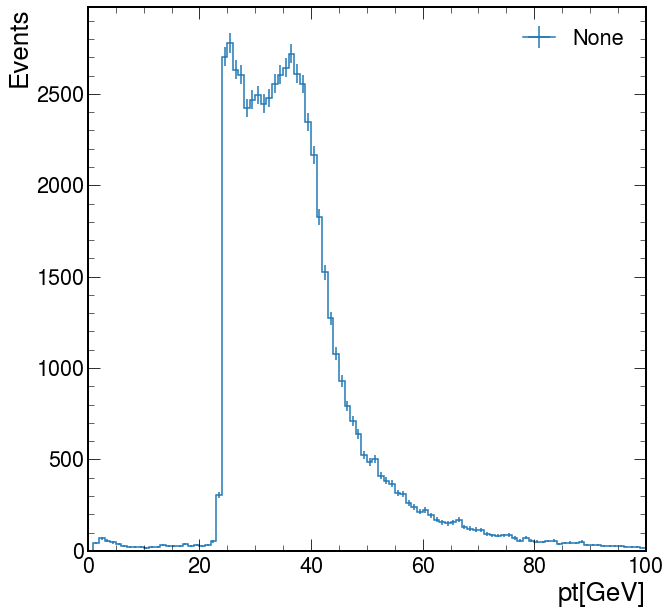

In [242]:
hist.plot1d(mu_pass)

<AxesSubplot:xlabel='pt[GeV]', ylabel='Events'>

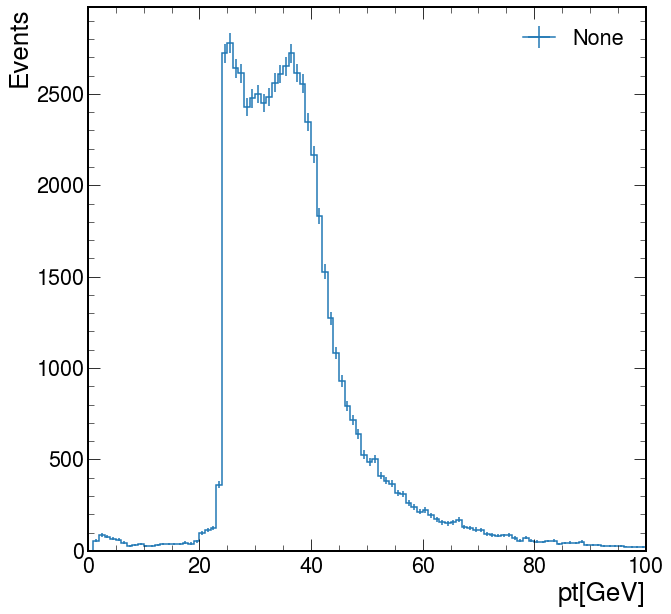

In [243]:
hist.plot1d(mu_all)

In [258]:
np.unique(lowPtmu.Quality)

<Array [13, 14, 15, 16, 17, ... 22, 23, 24, 25] type='12 * uint32'>

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


Text(0, 1, 'Efficiency')

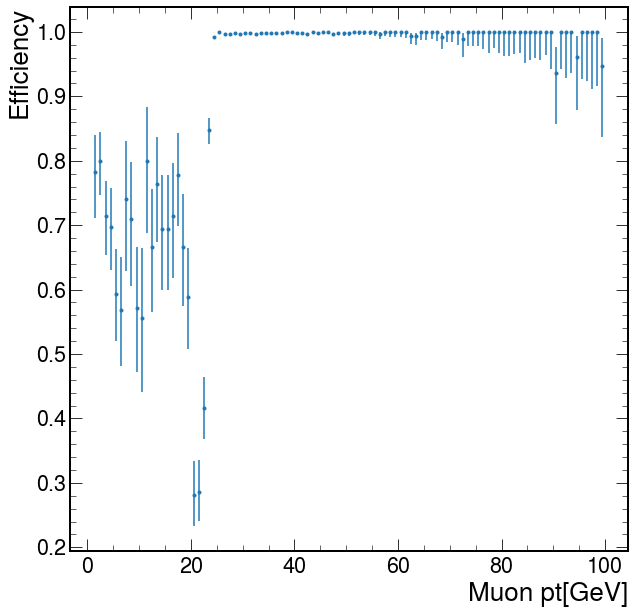

In [263]:
fig,ax = plt.subplots()
hist.plotratio(
    ax=ax,
    num  =mu_pass,
    denom=mu_all,
    error_opts={'marker': '.'},
    unc='clopper-pearson',
    clear=False,
    label="Efficiency"
)
ax.set_ylabel("Efficiency")

In [269]:
ele = ak.zip(
    {k.replace("ele_","").replace("ele",""):getattr(events,k) for k in events.fields 
     if (k.startswith("ele_") or k.startswith("ele")) and not "HLT" in k}
            ,with_name="PtEtaPhiELorentzVector", 
            behavior=vector.behavior
    )
ele["e"]   = ele["E"]
ele["phi"] = ele["Phi"]
ele['eta'] = ele["Eta"]
ele['pt']  = ele['Pt']
ele['isPOGTight']= ((abs(ele.Eta_SC)<1.479) & ele.passCutBasedIDTight & (abs(ele.d0)<0.05) & (abs(ele.dZ)<0.10)) |\
(ele.passCutBasedIDTight & (abs(ele.d0)<0.1) & (abs(ele.dZ)<0.2))

In [230]:
tightEle(ak.num(tightEle)==1)

TypeError: 'PtEtaPhiELorentzVectorArray' object is not callable

In [226]:
ak.num(tightEle)==1

<Array [False, False, False, ... False, False] type='66813 * bool'>

In [273]:
tightEle = ele[ele.isPOGTight]

ele_pass = hist.Hist("Events",hist.Bin("pt","electron pt[GeV]",40,0,100))
ele_all = hist.Hist("Events",hist.Bin("pt","electron pt[GeV]",40,0,100))
ele_pass.fill(pt=ak.flatten(tightEle[(SingleEleTrig==True) & (ak.num(tightEle)==1)].pt))
ele_all.fill(pt=ak.flatten(tightEle[(ak.num(tightEle)==1)].pt))

<AxesSubplot:xlabel='pt[GeV]', ylabel='Events'>

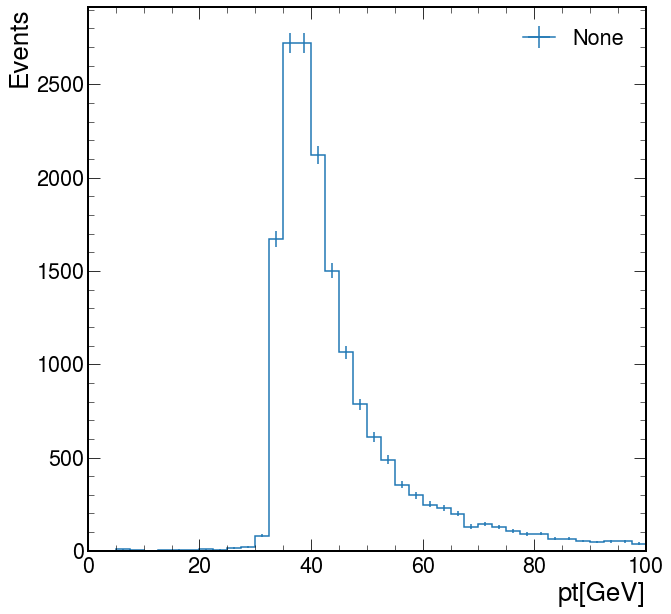

In [233]:
hist.plot1d(ele_pass)

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


Text(0, 1, 'Efficiency')

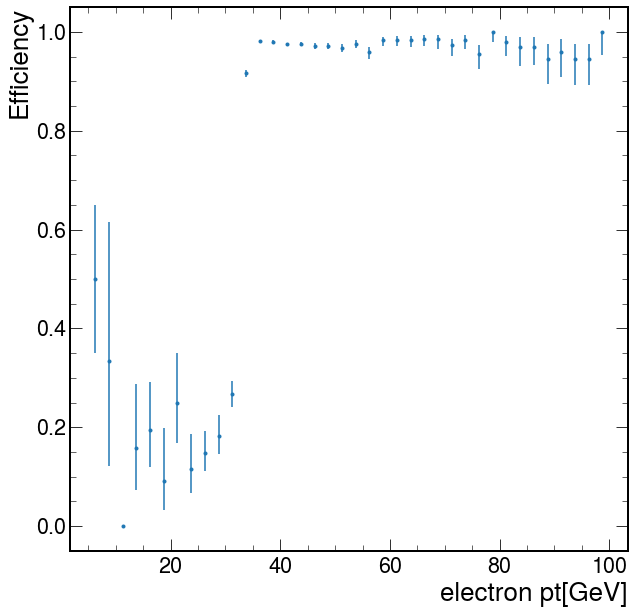

In [274]:
fig,ax = plt.subplots()
hist.plotratio(
    ax=ax,
    num  =ele_pass,
    denom=ele_all,
    error_opts={'marker': '.'},
    unc='clopper-pearson',
    clear=False
)
ax.set_ylabel("Efficiency")